In [1]:
import pandas as pd
import spacy
from IPython.display import display, HTML, Markdown
import random

fname = 'dataset.xlsx'
df = pd.read_excel(fname)
display(HTML(df.sample(10).to_html()))


,Type,Transcription
126,Deceptive,"I like her cause she’s really positive, and she always makes the environment very happy. Her laugh is contagious and she always has a smile on her face. Um and tries to make everybody else smile or laugh. An I really like her humor cause she can be pretty funny. She’s also really caring and sharing. Um she used to share chocolates and give everybody food uh if she had extra which was always nice. An She was always very helpful trying to give the best service that you can without being uh mean or anything to the customer."
309,Truthful,"At a party one time she walked in and her smile kind of lit up the room and I was just kind of very interested. Some of our interests our mutual interests are music, we both are like love country music um we’re going to see Florida Georgia line and Luke Bryan at some point un and in December we’re going to where is it, Kit More at Brick Street. Um we both get along very well, we like the same food and uh so I guess we’ve just really grown to like each other"
43,Deceptive,"Um. There’s this girl who lives down the hall from me and I literally see her all the time. And like it’s one of those things where like I would pass by her on campus and like I don’t know if I should say hi or not. And it’s really awkward because she lives in my dorm but like we just aren’t really close and then I always run into her in like the most awkward situations. So like I’ll like wake up late and like be a mess just waking up and she’ll be like perfectly dressed up and going to class as I’m like rolling out of bed. And, I don’t know, she just always seems to have like, this like pretentious air about her and I’m just like, can’t handle sometimes."
242,Truthful,"We met at school and she was the sweetest person I’ve met in the whole entire world. We instantly clicked. Um. We always hang out with each other whether it was at her house or my house, just walking around the neighborhood or playing games online or Facebook, anything. We just always together, always having fun. Um. She’s super nice. She’s really pretty. She’s super sweet. She’s like the best person in the world. If you met her you’d probably try to steal her from me as best friend. She’s amazing."
2,Deceptive,"We met in school and it was my first day there. I was new. And as soon as we met each other, it was like instant, we hated each other. It was horrible. Like we couldn’t sit next to each other in classes; we couldn’t work together on projects even in big groups. All teachers knew that because no matter what we were arguing because we just had so many different ideas that never worked. We were total opposites. Like, I don’t know why she hated as much as she did from the beginning but she did. And the feeling was mutual. Like, she’s just horrible person and I hate her guts still today."
150,Deceptive,"Since day one uh when we met we just kinda clicked and um it’s just been great since there. Uh he’s very down to earth. really guy really easy guy to get along with. Uh he’ll help you out with anything you need. He uh geez um he likes the same music as me. Uh We kinda have the same humor. Uh like the same movies. Um super nice guy, never tries to put ya down. Um and uh we’ve just, I mean, gosh we’ve clicked since day one. It’s been a great friendship so far and I can’t wait to see where it goes from here. But uh but yeah he’s just I mean he’s an awesome guy."
201,Truthful,"So I have this professor, he really kind of sucks um he’s really awkward and okay this really has nothing to do with his teaching but his hair is like long-ish, it’s like down to his shoulders and it’s blonde and like kind of curly, and it looks like he’s trying to be someone from the middle ages. Like I feel like he should be wearing tights to class. But this other thing that really annoys me is that he does the clicker questions and he feels the need to like read off the answers on the board which I clearly can already see so it’s just really redundant an

In [2]:

def printmd(string, color="Black"):
    colorstr = f"<span style='color:{color}'>{string}</span>"
    display(Markdown(colorstr))

### Count occurrences of specific words or types of words in both types of statements.  
### Visualize the proportion

In [3]:
from collections import Counter

right=0
wrong=0

nlp = spacy.load("en_core_web_sm")

def visualizeFeature(name, tcount, fcount):
    labels = ['Truthful', 'Deceptive']
    sizes = [tcount, fcount]
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90, textprops={'color': "black"})
    printmd(
        f"\n\n## **{name}:** {labels[0]} {tcount} {labels[1]} {fcount}")
    plt.show()



# Significance tests

H<sub>0</sub> : Words from wordlist are equally likely to occur in truthful and deceptive statements

H<sub>A</sub> : Words from wordlist occur in truthful and deceptive statements with different probability


**Sample**:  measure the proportion truthful/deceptive in the data

**Simulation**:  Generate 1000 pairs of 160 docs, randomly inserting words of interest according to the probability with which they occur in the text according to H<sub>0</sub>.  Of course, this kind of simulation is rather naïve, since actual language places a lot more constraints on the simulation.  Theoretically, an advanced generative model could be used to generate better data.  However, such simulation may be skewed, because generative models are typically trained on truthful data.

**Assumption**:  If less than 1% of the simulations show a truthful/deceptive proportion equal to or less (or greater, for proportions > 1) than the measured one, reject H<sub>0</sub>

If H<sub>0</sub> is rejected, the feature can be used to predict the veracity of a statement

In [4]:
#generate a set of "truthful" and "deceptive" "documents" with the same number of words
#count "occurrences" of a "word" that has a probability prob to appear in a "document"
def simstat(numdoc, numwords, prob):
  tcount = 0

  for i in range(numdoc):
      for j in range(numwords):
        if(random.uniform(0, 1) < prob):
          tcount += 1
  return tcount

#simulation:  1000 times generate 2 random documents, each containing words_per_doc


def simulation(numdoc, numwords, prob):

  sim = []
  for k in range(1000):
    sim.append(simstat(numdoc, int(words_per_doc), prob) /
               simstat(numdoc, int(words_per_doc), prob))
  return sim


In [5]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


def visualizeSimulation(sim, measured_proportion):
  #sort sim
  sim = sorted(sim)

  bottom = sim[int(0.01*len(sim))]
  top = sim[int(0.99*len(sim))]

  #count members of sim that are below the measured proportion
  below = sum(map(lambda x: x < measured_proportion, sim))
  #above = sum(map(lambda x: x > 1/measured_proportion, sim))

  alpha = 0.01
  pfactor = below/len(sim)

  plt.hist(sim, density=False, bins=30)  # density=False would make counts
  plt.ylabel('Frequency')
  plt.xlabel('Proportion')
  plt.show()

  print(
      f"Probability of getting a ratio at or below {measured_proportion:.2f}: {pfactor*100:.2f}%")

  if pfactor < alpha:
    printmd("Feature can be used for veracity assessment\n", color="green")
  else:
    printmd("Feature cannot be used for veracity assessment\n", color="red")
    



# Extract a few language features that Pennebaker claims can be used to assess veracity of written text.

The built-in "count_by" method of spaCy cannot be used because we want the ability to count not just spacific POS, but specific POS that are also a part of a short list.  For example, from the auxilliary verb group we only care about the modal verbs.  As it turns out, further splitting that group into two yields a really good results in terms of distribution between deceptive and truthful statements.

The idea is to count the occurences of members of each feature group in deceptive as well as truthful statements, and if they are unbalanced, perform a significance test.

In [6]:
import matplotlib.pyplot as plt
from spacy.tokens import Doc

def count_words(doc, type, wordlist):
    alloftype = [token.lower_ for token in doc if token.pos_ == type]
    
    if wordlist:
        alloftype = [x for x in alloftype if x in wordlist]

    return sum(Counter(alloftype).values())


<span style='color:Black'>

## **i-words:** Truthful 1303 Deceptive 1208</span>

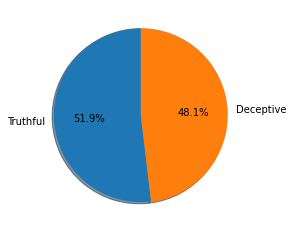

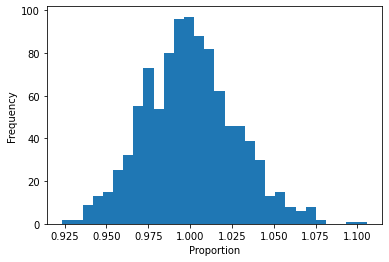

Probability of getting a ratio at or below 0.93: 0.20%


<span style='color:green'>Feature can be used for veracity assessment
</span>

<span style='color:Black'>

## **verbs:** Truthful 2625 Deceptive 2742</span>

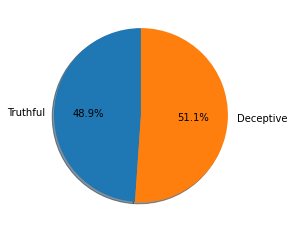

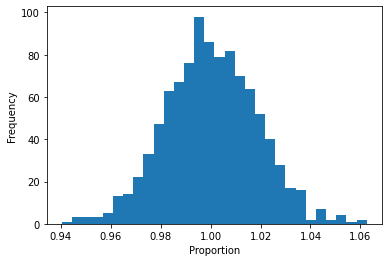

Probability of getting a ratio at or below 0.96: 1.10%


<span style='color:red'>Feature cannot be used for veracity assessment
</span>

<span style='color:Black'>

## **articles:** Truthful 686 Deceptive 672</span>

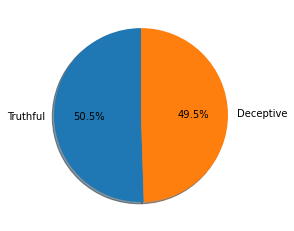

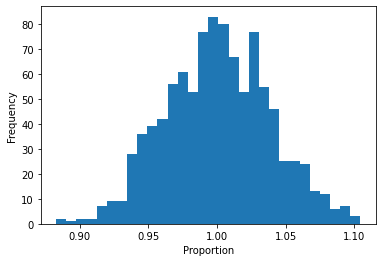

Probability of getting a ratio at or below 0.98: 30.40%


<span style='color:red'>Feature cannot be used for veracity assessment
</span>

<span style='color:Black'>

## **modal verbs 1:** Truthful 40 Deceptive 25</span>

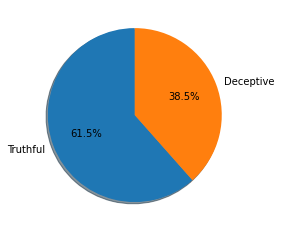

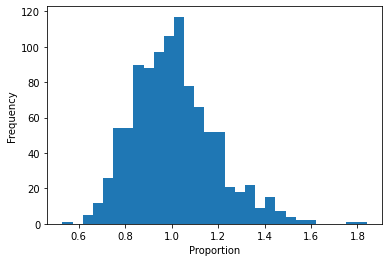

Probability of getting a ratio at or below 0.62: 0.10%


<span style='color:green'>Feature can be used for veracity assessment
</span>

<span style='color:Black'>

## **modal verbs 2:** Truthful 41 Deceptive 75</span>

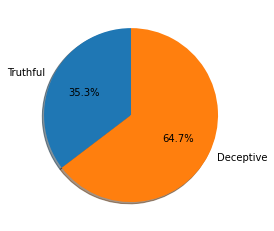

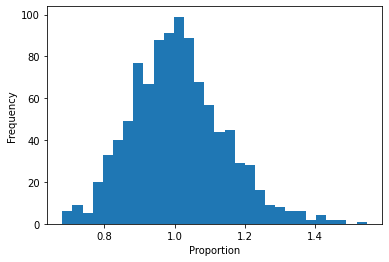

Probability of getting a ratio at or below 0.55: 0.00%


<span style='color:green'>Feature can be used for veracity assessment
</span>

<span style='color:Black'>

## **cognitive verbs:** Truthful 170 Deceptive 211</span>

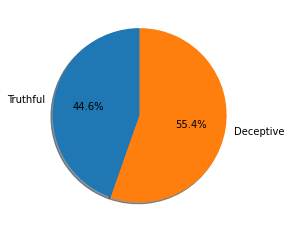

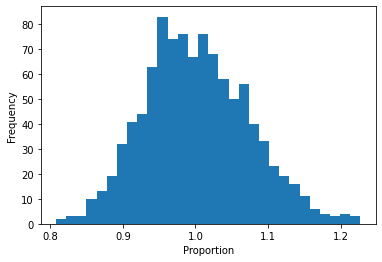

Probability of getting a ratio at or below 0.81: 0.00%


<span style='color:green'>Feature can be used for veracity assessment
</span>

<span style='color:Black'>

## **interjections:** Truthful 710 Deceptive 725</span>

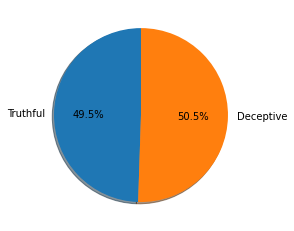

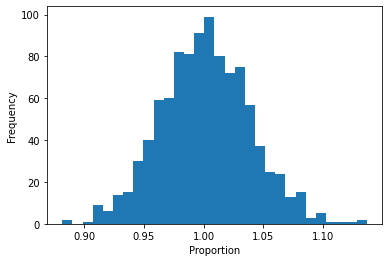

Probability of getting a ratio at or below 0.98: 27.60%


<span style='color:red'>Feature cannot be used for veracity assessment
</span>

In [7]:

featureTypes=[
    {
        'name':'i-words',
        'POS':'PRON',
        'wordlist': ['we','i', 'me', 'myself', 'my', 'mine'],
        'tcount':0,
        'fcount':0,
        'indicates':None
    },
    {
        'name': 'verbs',
        'POS': 'VERB',
        'wordlist': None,
        'tcount': 0,
        'fcount': 0,
        'indicates': None
    },
    {
        'name': 'articles',
        'POS': 'DET',
        'wordlist': ['a', 'an', 'the'],
        'tcount':0,
        'fcount':0,
        'indicates':None
    },
    {
        'name': 'modal verbs 1',
        'POS': 'AUX',
        'wordlist': ["could", "should"], 
        'tcount': 0,
        'fcount': 0,
        'indicates':None
    },
    {
        'name': 'modal verbs 2',
        'POS': 'AUX',
        'wordlist': ["would", "may"],
        'tcount': 0,
        'fcount': 0,
        'indicates':None
    },
    {
        'name': 'cognitive verbs',
        'POS': 'VERB',
        'wordlist': ['realize' , 'think', 'understand', 'figure', 'derive', "know", "believe", "recognize", "appreciates"],
        'tcount': 0,
        'fcount': 0,
        'indicates':None
    },
    {
        'name': 'interjections',
        'POS': 'INTJ',
        'wordlist': None,
        'tcount': 0,
        'fcount': 0,
        'indicates': None
    }
]

twcount = 0
fwcount = 0

docs = []
labels = []

for index, row in df.iterrows():
    text = row['Transcription']
    doc = nlp(text)
    docs.append(doc)
    labels.append(row['Type'])


cdoc = Doc.from_docs(docs)

for doc, label in zip(docs, labels):
    for feature in featureTypes:
        if label == 'Truthful':
            feature['tcount'] += count_words(doc, feature['POS'], feature['wordlist'])
        else:
            feature['fcount'] += count_words(doc, feature['POS'], feature['wordlist'])

    if label == 'Truthful':
        twcount += len(doc)  
    else:
        fwcount += len(doc) 

numdocs = len(docs)
total_wordcount = twcount + fwcount
words_per_doc = total_wordcount/len(docs)

for feature in featureTypes:
  listlen = len(feature['wordlist']) if feature['wordlist'] else 1
  global_occurences = feature['tcount'] + feature['fcount']
  visualizeFeature(feature['name'], feature['tcount'], feature['fcount'])
  prob = global_occurences/total_wordcount
  sim = simulation(numdocs, words_per_doc, prob)
  measured_proportion = feature['tcount']/feature['fcount']
  if measured_proportion > 1. :
    measured_proportion = 1./measured_proportion
    feature['indicates'] = 'truthful'
  else:
    feature['indicates'] = 'deceptive'
    
  visualizeSimulation(sim, measured_proportion)



Next steps:  construct features by checking for the presence of multiple significant words in a statement.  

Perhaps add a score, either 1 for each significant word present, or assign different weight based on the calculated significance 

In [8]:
def pos_list(doc, pos):
    pos_list = [token.lemma for token in doc if token.pos_ == pos]
    return Counter(pos_list)


def rwratio(lieword, trueword, counter):
    right = 0
    wrong = 0

    if counter[lieword] > counter[trueword] and label == 'Truthful':
        wrong += 1
    elif counter[lieword] < counter[trueword] and label == 'Deceptive':
        wrong += 1
    elif counter[lieword] != counter[trueword]:
        right += 1
    return right, wrong


In [30]:


MINSCORE = 0 
def veval(doc, features):

  tscore = 0
  fscore = 0

  for feature in features:
    fcount = count_words(doc, feature['POS'], feature['wordlist'])
    if feature['indicates'] == 'truthful':
      tscore += fcount
    else:
      fscore += fcount
      #print(f"{feature['name']} {fcount}")

  score = tscore - fscore/2 #compensate for the feature set being unbalanced

  if score == 0:
    return score
  elif score > 0:
    return 'Truthful'
  else:
    return 'Deceptive'



right = 0
wrong = 0

usable_features = ['modal verbs 1', 'modal verbs 2', 'cognitive verbs']
features = [x for x in featureTypes if x['name'] in usable_features]

for doc, label in zip(docs, labels):
    score = veval(doc, features)
    if score != 0:
      if score == label:
        right += 1
      else:
        wrong += 1

print(f"Right: {right}")
print(f"Wrong: {wrong}")
print(f"Accuracy: {right/(right+wrong)*100:.2f}%")





    

Right: 126
Wrong: 94
Accuracy: 57.27%
